In [1]:
using JuMP, Ipopt
using CSV, DataFrames, DataStructures, MathOptFormat
using Statistics,Distributions, StatsFuns, StatsBase
using PyPlot
using Random

In [65]:
include("LRO.jl")
include("utils.jl")
include("non_DRO_methods.jl")

SAA (generic function with 1 method)

In [3]:
# normdata.csv -- author provided, normally distributed data
df_norm = CSV.read("normdata.csv", DataFrame, header=false)

print("Normal data results:", "\n")

#sanity check on output of LRO
print("LRO OPT moment x*:", LRO_opt(df_norm, 0, false),"\n")

# sanity check on LRO with moment information
print("LRO OPT w/ moment x*: ", LRO_opt(df_norm, 0, true),"\n")

#sanity check on scarf
print("Scarf x*: ", scarf(df_norm),"\n")

#sanity check on SAA
print("SAA x*: ", SAA(df_norm),"\n")

# sanity check on critical fractile (true distribution)
print("Crtical Fractile x*: ", critical_fractile("norm"))

Normal data results:

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

LRO OPT moment x*:55.99999993660837
LRO OPT w/ moment x*: 52.05887909429087
Scarf x*: 53.016
SAA x*: 48.99999661256657
Crtical Fractile x*: 50.0

In [66]:
#sanity check that SAA can be recovered (see appendix of write up)
print("SSA recovery (using LRO) x*:", LRO_opt(df_norm, 0, false, nothing, true),"\n")

LRO OPT moment x*:48.99999986880749


In [4]:
# expdata.csv -- author provided, normally distributed data
df_exp = CSV.read("expdata.csv", DataFrame,header=false)

print("Exponential data results:", "\n")

#sanity check on output of LRO
print("LRO OPT moment x*:", LRO_opt(df_exp, 0, false),"\n")

# sanity check on LRO with moment information
print("LRO OPT w/ moment x*: ",LRO_opt(df_exp, 0, true),"\n")

#sanity check on scarf
print("Scarf x*: ", scarf(df_exp),"\n")

#sanity check on SAA
print("SAA x*: ", SAA(df_exp),"\n")

# sanity check on true distribution
print("Crtical Fractile x*: ", critical_fractile("exp"))

Exponential data results:
LRO OPT moment x*:45.999999790861075
LRO OPT w/ moment x*: 33.10719193154016
Scarf x*: 49.743
SAA x*: 34.99998823805423
Crtical Fractile x*: 34.65735803050322

In [5]:
#sanity check on x* (stocking quantity) as we vary the size of the ambiguity set
x_opt_values = Vector{Float64}()

gamma_vals = -50:1:50    # list of values for which we will vary the value of gamma^* by

for gamma in gamma_vals 
    x_opt = LRO_opt(df_norm, gamma, false)
    append!(x_opt_values,x_opt)
end 

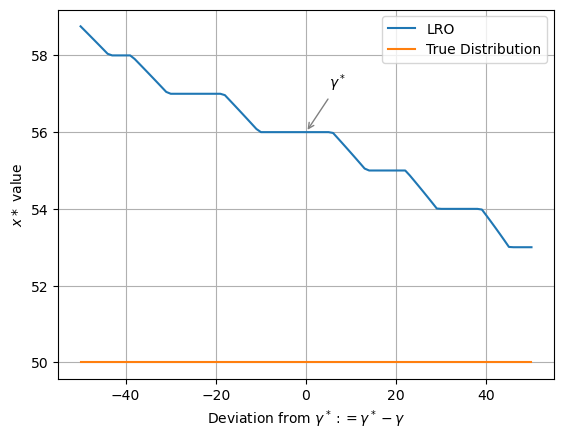

In [31]:
#graph sanity check of varying the value of gamma
#plots the optimal stocking quantity x^* as a funcion of gamma
#additionally displays the x^* under the true distribution

plot(gamma_vals, x_opt_values,label="LRO")
plot(gamma_vals, ones(size(gamma_vals)) * 50,label="True Distribution")

xlabel( L"Deviation from $\gamma^*:= \gamma^* - \gamma$ ")
ylabel(L"$x*$ value")

legend()
grid("on")

dx = maximum(gamma_vals) - minimum(gamma_vals)
dy = maximum(x_opt_values) - minimum(x_opt_values)

#graph arrow to point out \gamma^*
annotate(L"$\gamma^*$ ",
xy=[gamma_vals[51];x_opt_values[51]],
xytext=[gamma_vals[51]+0.05dx;x_opt_values[51]+0.2dy],
xycoords="data",
arrowprops=Dict("arrowstyle"=>"->","color"=>"gray")) 

#save figure to put in Overleaf
savefig("gamma_results.pdf")

In [7]:
function vary_sample_size(max_dist_size, dist_name, start_samp, skip_samp)
    # calculate x* as function of sample size of simulated data (not the data used in paper)
    # max_dist_size - int, maximum number of iterations to run over
    # dist_name - string, "norm" or "exp" to use normal or exponential distribution, respectively
    # start_samp - int, number of iterations to start at
    # skip_samp - int, number of iterations to increase by each run
    
    #vectors to store final values
    LRO_values_tot_norm = Vector{Vector{Float64}}()
    LRO_moment_values_tot_norm = Vector{Vector{Float64}}()
    scarf_values_tot_norm  = Vector{Vector{Float64}}()
    SAA_values_tot_norm  = Vector{Vector{Float64}}()
    
    for iter in 1:10
        print("iteration: ", iter, "\n")
        Random.seed!(iter) #set seed

        dist_size = max_dist_size # max number of samples

        dist = nothing 
        if dist_name == "norm"
            dist = Normal(50,50)
            
        elseif dist_name == "exp"
            dist = Exponential(50)
        end
        
        # randomly sample data
        samp = rand(dist,dist_size)
        samp = trunc.(Int,samp)

        for i in 1:length(samp)  # truncate values between [0,200] (as done in the paper)
            val = samp[i]
            while val < 0 || val > 200
                val = trunc.(Int,rand(dist))
            end
            samp[i] = val
        end

        df_sim = DataFrame()

        df_sim.Column1 = samp
        
        #vectors to store intermediary
        LRO_values = Vector{Float64}()
        LRO_moment_values = Vector{Float64}()
        scarf_values = Vector{Float64}()
        SAA_values = Vector{Float64}()

        for i in start_samp:skip_samp:dist_size  #vary sample size from [250,3000] by 150 each iteration
            df_samp = df_sim[shuffle(1:nrow(df_sim))[1:i], :] #sample data
            
            #cacluate x^* for each method and store
            lro = LRO_opt(df_samp,0,false)
            append!(LRO_values, lro)

            lro_moment = LRO_opt(df_samp,0,true)
            append!(LRO_moment_values, lro_moment)

            scarf_val = scarf(df_samp)
            append!(scarf_values, scarf_val)

            saa = SAA(df_samp)
            append!(SAA_values, saa)
        end

        append!(LRO_values_tot_norm , [LRO_values])
        append!(LRO_moment_values_tot_norm , [LRO_moment_values])
        append!(scarf_values_tot_norm , [scarf_values])
        append!(SAA_values_tot_norm , [SAA_values])
    end
    
return [LRO_values_tot_norm, LRO_moment_values_tot_norm, scarf_values_tot_norm, SAA_values_tot_norm]
    
end

vary_sample_size (generic function with 1 method)

In [8]:
max_sample = 3000
start_sample = 250
skip_sample = 150

#vary over normal distribution
sample_norm = vary_sample_size(max_sample, "norm", start_sample, skip_sample);

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10


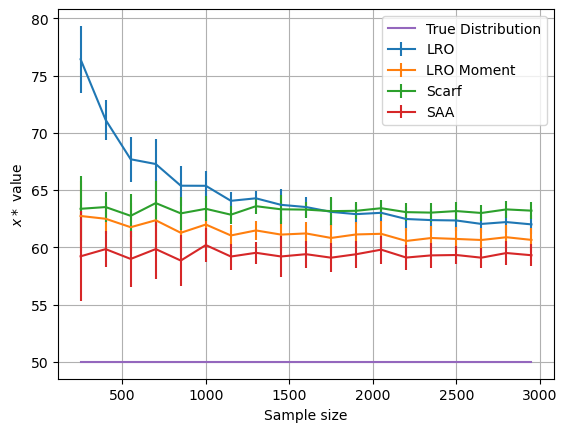

In [32]:
#plot error bars for methods
errorbar(start_sample:skip_sample:max_sample, mean(sample_norm[1]), std(sample_norm[1]), label="LRO")
errorbar(start_sample:skip_sample:max_sample, mean(sample_norm[2]), std(sample_norm[2]), label="LRO Moment")
errorbar(start_sample:skip_sample:max_sample, mean(sample_norm[3]), std(sample_norm[3]), label="Scarf")
errorbar(start_sample:skip_sample:max_sample, mean(sample_norm[4]), std(sample_norm[4]), label="SAA")

plot(start_sample:skip_sample:max_sample, ones(length(start_sample:skip_sample:max_sample)) * critical_fractile("norm"), label="True Distribution")

xlabel("Sample size")
ylabel(L"$x*$ value")

legend()
grid("on")

savefig("normal_vary_sample_size.pdf")

In [10]:
#vary over exponential distribution
sample_exp = vary_sample_size(max_sample, "exp", start_sample, skip_sample);

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10


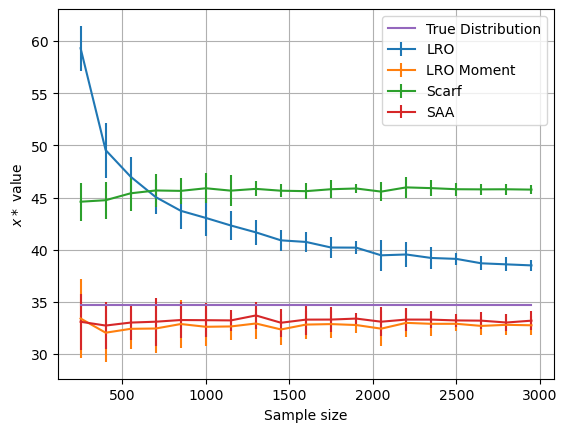

In [33]:
#plot error bars for methods
errorbar(start_sample:skip_sample:max_sample, mean(sample_exp[1]), std(sample_exp[1]), label="LRO")
errorbar(start_sample:skip_sample:max_sample, mean(sample_exp[2]), std(sample_exp[2]), label="LRO Moment")
errorbar(start_sample:skip_sample:max_sample, mean(sample_exp[3]), std(sample_exp[3]), label="Scarf")
errorbar(start_sample:skip_sample:max_sample, mean(sample_exp[4]), std(sample_exp[4]), label="SAA")

plot(start_sample:skip_sample:max_sample, ones(length(start_sample:skip_sample:max_sample)) * critical_fractile("exp"), label="True Distribution")

xlabel("Sample size")
ylabel(L"$x*$ value")

legend()
grid("on")

savefig("exponential_vary_sample_size.pdf")

In [35]:
# costs when distribution comes from true distribution (normal)

LRO_obj =  Vector{Float64}()
LRO_mom_obj =  Vector{Float64}()
scarf_obj = Vector{Float64}()
saa_obj =  Vector{Float64}()
opt_obj =  Vector{Float64}()

demand = rand(Normal(50,50),10000)

for i in 1:length(demand)  # truncate values between [0,200] (as done in the paper)
        val = demand[i]
        while val < 0 || val > 200
            val = trunc.(Int,rand(Normal(50,50)))
        end
        demand[i] = val
    end
demand = trunc.(Int,demand)

#evaluate cost for each method, annoyingly split up because of having to compute cost w.r.t. true distribution
for j in 1:length(start_sample:skip_sample:max_sample)
    obj_func = 0
    for d in demand
        obj_func += abs(d - mean(sample_norm[1])[j])
    end
    append!(LRO_obj, obj_func / 10000)
end

for j in 1:length(start_sample:skip_sample:max_sample)    
    obj_func = 0
      for d in demand
        obj_func += abs(d -  mean(sample_norm[2])[j])
    end
    append!(LRO_mom_obj, obj_func / 10000)
end

for j in 1:length(start_sample:skip_sample:max_sample)  
    obj_func = 0
    for d in demand
        obj_func += abs(d -  mean(sample_norm[3])[j])
    end 
    append!(scarf_obj, obj_func / 10000)
end

for j in 1:length(start_sample:skip_sample:max_sample) 
    obj_func = 0
    for d in demand
        obj_func += abs(d -  mean(sample_norm[4])[j])
    end  
    append!(saa_obj, obj_func / 10000)
end

for j in 1:length(start_sample:skip_sample:max_sample) 
    obj_func = 0
    for d in demand
        obj_func += abs(d - 50)
    end  
    append!(opt_obj, obj_func / 10000)
end


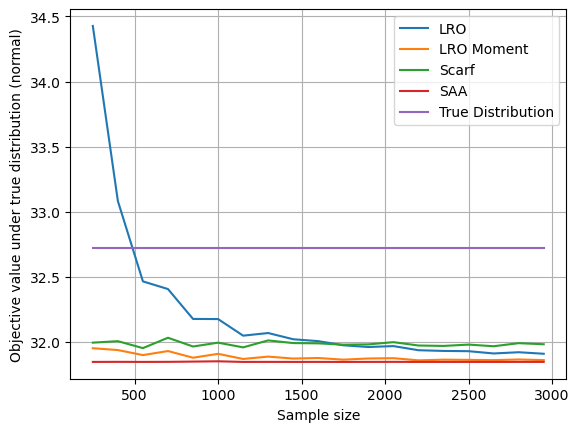

In [36]:
#plot cost with respect to true distribution (norm)

plot(start_sample:skip_sample:max_sample, LRO_obj, label="LRO")
plot(start_sample:skip_sample:max_sample, LRO_mom_obj, label="LRO Moment")
plot(start_sample:skip_sample:max_sample, scarf_obj , label="Scarf")
plot(start_sample:skip_sample:max_sample, saa_obj, label="SAA")

plot(start_sample:skip_sample:max_sample, opt_obj, label="True Distribution")

xlabel("Sample size")
ylabel("Objective value under true distribution (normal)")

legend()
grid("on")

savefig("normal_obj_true_dist.pdf")

In [37]:
# costs when distribution comes from true distribution (exponential)

LRO_obj =  Vector{Float64}()
LRO_mom_obj =  Vector{Float64}()
scarf_obj = Vector{Float64}()
saa_obj =  Vector{Float64}()
opt_obj =  Vector{Float64}()

demand = rand(Exponential(50),10000)

for i in 1:length(demand)  # truncate values between [0,200] (as done in the paper)
        val = demand[i]
        while val < 0 || val > 200
            val = trunc.(Int,rand(Exponential(50)))
        end
        demand[i] = val
    end
demand = trunc.(Int,demand)


#evaluate cost for each method, annoyingly split up because of having to compute cost w.r.t. true distribution
for j in 1:length(start_sample:skip_sample:max_sample)
    obj_func = 0
    for d in demand
        obj_func += abs(d - mean(sample_norm[1])[j])
    end
    append!(LRO_obj, obj_func / 10000)
end

for j in 1:length(start_sample:skip_sample:max_sample)    
    obj_func = 0
      for d in demand
        obj_func += abs(d -  mean(sample_norm[2])[j])
    end
    append!(LRO_mom_obj, obj_func / 10000)
end

for j in 1:length(start_sample:skip_sample:max_sample)  
    obj_func = 0
    for d in demand
        obj_func += abs(d -  mean(sample_norm[3])[j])
    end 
    append!(scarf_obj, obj_func / 10000)
end

for j in 1:length(start_sample:skip_sample:max_sample) 
    obj_func = 0
    for d in demand
        obj_func += abs(d -  mean(sample_norm[4])[j])
    end  
    append!(saa_obj, obj_func / 10000)
end

for j in 1:length(start_sample:skip_sample:max_sample) 
    obj_func = 0
    for d in demand
        obj_func += abs(d - 50)
    end  
    append!(opt_obj, obj_func / 10000)
end


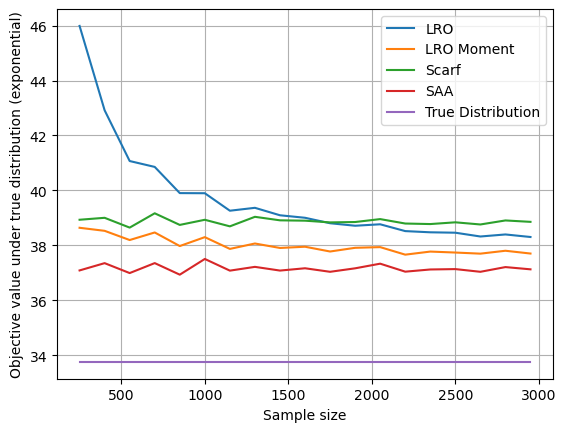

In [38]:
#plot cost with respect to true distribution (exp)

plot(start_sample:skip_sample:max_sample,LRO_obj, label="LRO")
plot(start_sample:skip_sample:max_sample, LRO_mom_obj, label="LRO Moment")
plot(start_sample:skip_sample:max_sample, scarf_obj , label="Scarf")
plot(start_sample:skip_sample:max_sample, saa_obj, label="SAA")

plot(start_sample:skip_sample:max_sample, opt_obj, label="True Distribution")
xlabel("Sample size")
ylabel("Objective value under true distribution (exponential)")

legend()
grid("on")
savefig("exp_obj_true_dist.pdf")

In [46]:
#costs when distribution comes from D(\gamma) (norm)

dist_size = 3000 # maximum number of samples

dist = Normal(50,50)

#sample data
samp = rand(dist,dist_size)
samp = trunc.(Int,samp)

for i in 1:length(samp)  # truncate values between [0,200] (as done in the paper)
    val = samp[i]
    while val < 0 || val > 200
        val = trunc.(Int,rand(dist))
    end
    samp[i] = val
end

df_sim = DataFrame()

df_sim.Column1 = samp

# to store objective function values 
LRO_obj_values_dgamma = Vector{Float64}()
LRO_moment_obj_values_dgamma = Vector{Float64}()
scarf_obj_values_dgamma  = Vector{Float64}()
SAA_obj_values_dgamma  = Vector{Float64}()
opt_obj_values_dgamma = Vector{Float64}()

# fix x == i for each mean value in each method
for i in mean(sample_norm[1])
    LRO_obj = LRO_opt(df_sim,0,false,i)
    append!(LRO_obj_values_dgamma , LRO_obj)
end
    
for i in  mean(sample_norm[2])
    LRO_moment_obj = LRO_opt(df_sim,0,false,i)
    append!(LRO_moment_obj_values_dgamma, LRO_moment_obj)
end
        
for i in  mean(sample_norm[3])
    scarf_obj = LRO_opt(df_sim,0,false,i)
    append!(scarf_obj_values_dgamma , scarf_obj)
end
            
for i in  mean(sample_norm[4])
    saa_obj = LRO_opt(df_sim,0,false,i)
    append!(SAA_obj_values_dgamma , saa_obj)
end

for i in  mean(sample_norm[4])
    opt_obj = LRO_opt(df_sim,0,false,50)
    append!(opt_obj_values_dgamma , opt_obj)
end

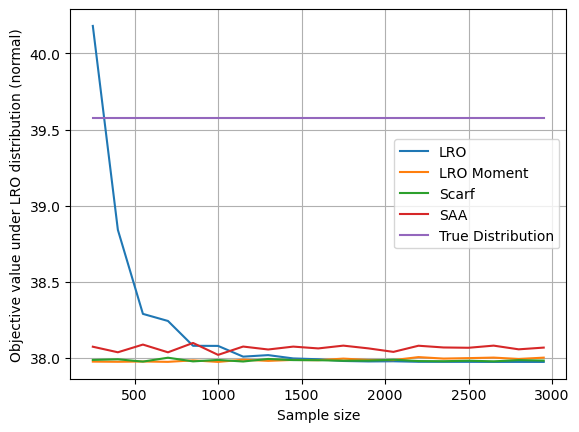

In [47]:
#plot costs when distribution from ambiguity set (normal)

plot(start_sample:skip_sample:max_sample,LRO_obj_values_dgamma, label="LRO")
plot(start_sample:skip_sample:max_sample, LRO_moment_obj_values_dgamma, label="LRO Moment")
plot(start_sample:skip_sample:max_sample, scarf_obj_values_dgamma , label="Scarf")
plot(start_sample:skip_sample:max_sample, SAA_obj_values_dgamma, label="SAA")

plot(start_sample:skip_sample:max_sample, opt_obj_values_dgamma, label="True Distribution")
xlabel("Sample size")
ylabel("Objective value under LRO distribution (normal)")

legend()
grid("on")
savefig("normal_obj_LRO_dist.pdf")

In [49]:
# costs when distribution comes from D(\gamma) (exp)

dist_size = 3000 # maximum number of samples

dist = Exponential(50)

#sample data
samp = rand(dist,dist_size)
samp = trunc.(Int,samp)

for i in 1:length(samp)  # truncate values between [0,200] (as done in the paper)
    val = samp[i]
    while val < 0 || val > 200
        val = trunc.(Int,rand(dist))
    end
    samp[i] = val
end

df_sim = DataFrame()

df_sim.Column1 = samp

# to store objective function values 
LRO_obj_values_dgamma = Vector{Float64}()
LRO_moment_obj_values_dgamma = Vector{Float64}()
scarf_obj_values_dgamma  = Vector{Float64}()
SAA_obj_values_dgamma  = Vector{Float64}()
opt_obj_values_dgamma = Vector{Float64}()

# fix x == i for each mean value in each method
for i in mean(sample_exp[1])
    LRO_obj = LRO_opt(df_sim,0,false,i)
    append!(LRO_obj_values_dgamma , LRO_obj)
end
    
for i in mean(sample_exp[2])
    LRO_moment_obj = LRO_opt(df_sim,0,false,i)
    append!(LRO_moment_obj_values_dgamma, LRO_moment_obj)
end
        
for i in  mean(sample_exp[3])
    scarf_obj = LRO_opt(df_sim,0,false,i)
    append!(scarf_obj_values_dgamma , scarf_obj)
end
            
for i in  mean(sample_exp[4])
    saa_obj = LRO_opt(df_sim,0,false,i)
    append!(SAA_obj_values_dgamma , saa_obj)
end

for i in  mean(sample_exp[4])
    opt_obj = LRO_opt(df_sim,0,false,critical_fractile("exp"))
    append!(opt_obj_values_dgamma , opt_obj)
end

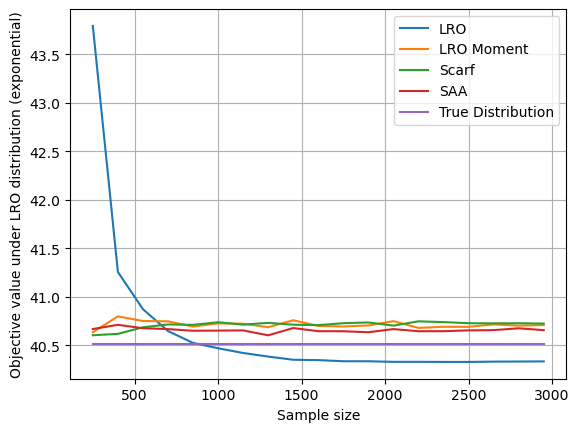

In [50]:
#plot costs when distribution from ambiguity set (exp)

plot(start_sample:skip_sample:max_sample,LRO_obj_values_dgamma, label="LRO")
plot(start_sample:skip_sample:max_sample, LRO_moment_obj_values_dgamma, label="LRO Moment")
plot(start_sample:skip_sample:max_sample, scarf_obj_values_dgamma , label="Scarf")
plot(start_sample:skip_sample:max_sample, SAA_obj_values_dgamma, label="SAA")

plot(start_sample:skip_sample:max_sample, opt_obj_values_dgamma, label="True Distribution")
xlabel("Sample size")
ylabel("Objective value under LRO distribution (exponential)")

legend()
grid("on")
savefig("exp_obj_LRO_dist.pdf")